In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dataset

from torch.utils.data import DataLoader

In [2]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(),
    transforms.ToTensor()
])

In [3]:
data = dataset.ImageFolder('../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets' , transform = transform)


In [4]:
datalen = len(data)
dataidx = np.array(list(range(datalen)))
np.random.shuffle(dataidx)

splitfrac = 0.9
split_idx = int(splitfrac * datalen)
train_idxs = dataidx[:split_idx]
valid_idxs = dataidx[split_idx:]

testsplit = 0.1
testidxs = int(testsplit * len(train_idxs))


test_idxs = train_idxs[:testidxs]
train_idxs = train_idxs[testidxs:]

np.random.shuffle(test_idxs)

In [5]:
batch_size = 30

In [6]:
train_samples = torch.utils.data.SubsetRandomSampler(train_idxs)
valid_samples = torch.utils.data.SubsetRandomSampler(valid_idxs)
test_samples  = torch.utils.data.SubsetRandomSampler(test_idxs)
dataloader = DataLoader(data , batch_size = batch_size , sampler = train_samples)
validloader = DataLoader(data , batch_size = batch_size ,sampler = valid_samples)
testloader  = DataLoader(data , batch_size = batch_size , sampler = test_samples)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  import sys


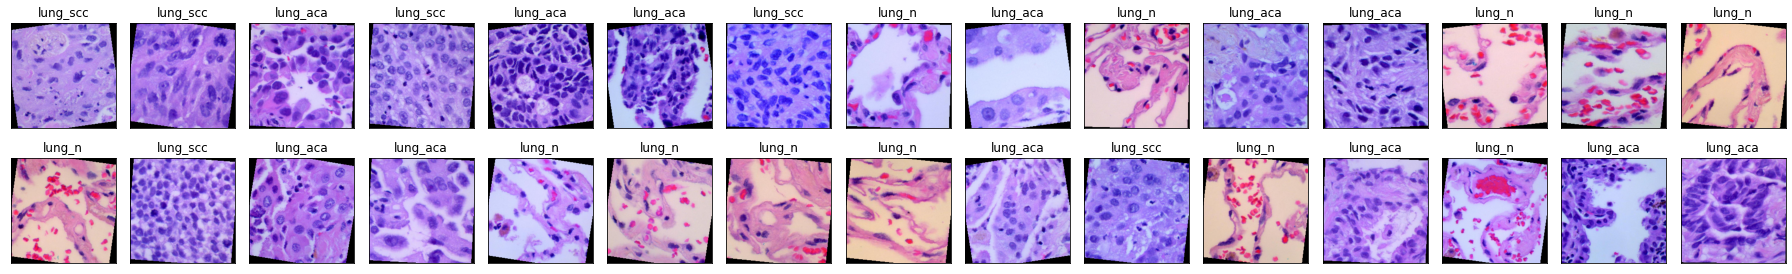

In [7]:
images , labels = iter(dataloader).next()
images , labels = images.numpy() , labels.numpy()

fig = plt.figure(figsize = (25,4))

for i in range(batch_size):
    ax = fig.add_subplot(2 , batch_size/2 , i+1 , xticks = [] , yticks = [])
    ax.imshow(images[i].transpose(2,1,0).squeeze())
    ax.set_title(data.classes[labels[i]])
    
plt.tight_layout()

In [8]:
from torchvision import models
model = models.vgg16(pretrained = True)


# Parameters -> Do not perform gradient decent -> Freeze

for param in model.parameters():
    param.no_grad_ = True

model.classifier[6] = nn.Linear(4096 , 3)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [9]:
model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters() , lr = 1e-5)

In [11]:
%timeit
n_epochs = 1

for e in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    min_valid_loss = np.inf
    model.train()
    for batch_idx , (data , target) in enumerate(dataloader):
        data = data.cuda()
        target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output , target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    model.eval()
    for batch_idx , (data , target) in enumerate(validloader):
        data = data.cuda()
        target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output , target)
        valid_loss += loss.item()
            
        
    train_loss = train_loss / len(dataloader)
    valid_loss = valid_loss / len(validloader)
    print("Epoch : {} , Batch : {} , Loss : {}".format(e+1 , batch_idx , train_loss)) 
    
    if valid_loss < min_valid_loss:
        print("Valid Loss decreased from {} ---> {}".format(min_valid_loss , valid_loss))    
        torch.save(model.state_dict() , "model_lung_canc.pt")
        min_valid_loss = valid_loss


Epoch : 1 , Batch : 49 , Loss : 0.18040520711169566
Valid Loss decreased from inf ---> 0.057006154088303444


In [12]:
def test(loaders, model, criterion, use_cuda  = True):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [13]:
test(testloader, model, criterion, use_cuda  = True)

Test Loss: 0.052505


Test Accuracy: 98% (1324/1350)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


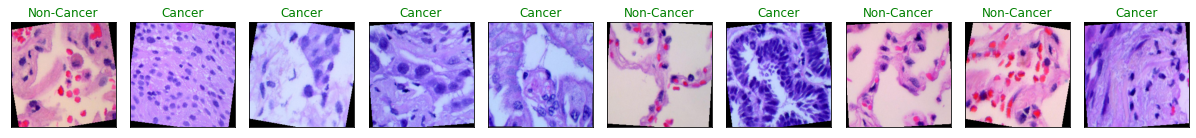

In [14]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(model(images.cuda()).data.max(1, keepdim=True)[1].cpu().numpy())
images = images.cpu().numpy()

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx].transpose(1,2,0)), cmap='gray')
    if(labels[idx] == 0 or labels[idx] == 2):
        ax.set_title("Cancer",
                 color=("green" if preds[idx]==labels[idx] else "red"))
    else:
        ax.set_title("Non-Cancer",
                 color=("green" if preds[idx]==labels[idx] else "red"))
plt.tight_layout()